# Step 3: Generate terminus position timeseries along flowlines

By Jukes Liu (jukesliu@boisestate.edu)

_Last modified 2022-05-03._


This script is run after the WTMM analysis is complete in order to extract terminus positions from the automated delinations. Relative terminus positions are calculated along three glacier flowlines, created automatically using the glacier terminus box.

The code is streamlined to analyze images for hundreds of glaciers, specifically, the marine-terminating glaciers along the periphery of Greenland. For use on other glaciers, sections of code must be modified:

##########################################################################################

__Indicates code that must be modified__

##########################################################################################

### Notebook sections:
- 1) Grab BoxIDs for the glaciers
- 2) Automatically generate glacier flowlines from terminus boxes
    - 2.1) first method
    - 2.2) try second method where first method failed
- 3) Generate terminus position time series
    - 3.1) from python WTMM results
        - 3.1.1) option 1: run in series
        - 3.1.2) option 2: run in parallel
    - 3.2) from Xsmurf WTMM results

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pylab as pl
import os
import subprocess
import shutil
import fiona
from shapely.geometry import Polygon, Point
import shapely
import cv2
import json
import scipy.stats
import datetime
import math
from multiprocessing import Pool

######################################################################################
basepath = '/home/jukes/Documents/Sample_glaciers/' # path to directory containing folders with terminus boxes
# os.chdir('/Users/jukesliu/Documents/AUTO-TERMINUS/automated-glacier-terminus')
######################################################################################

# import necessary functions from automated-glacier-terminus.py
from automated_terminus_functions import *

# 1) Grab the BoxIDs for the glaciers

In [ ]:
# # Run one at a time
# BoxIDs = ['174']

In [9]:
# Use one of the csv files to grab multiple glacier BoxIDs
######################################################################################
VEL_FILENAME = 'Glacier_vel_manual_all.csv' # name of velocity file generated in preprocess.ipynb Step 7
######################################################################################
velocities_df = pd.read_csv(basepath+VEL_FILENAME, sep=',', dtype=str)
velocities_df = velocities_df.set_index('BoxID')
BoxIDs = list(velocities_df.index)
print(BoxIDs)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143'

# 2) Automatically generate glacier flowlines from terminus boxes

The vertices of the glacier terminus box (in pixel coordinates) will be used to calculate a 3 points (1/4, 1/2, 3/4 across the box width)  on the left edge of the terminus box, which will be our reference point for calculating terminus position. There are 2 methods to finding the correct corners and can be treated as 2 passes. If one fails, try the next. If both fail, find and enter the values manually.

In [22]:
# one of the vertex-finding algorithms requires the minimum dimension of the box (width or length)
# which was generated in preprocess.ipynb Step 5
######################################################################################
BOX_FILENAME = 'Buffdist_174.csv' # file generated from preprocess.ipynb Step 5
######################################################################################
dim_df = pd.read_csv(basepath+BOX_FILENAME, sep=',', dtype=str) 
dim_df = dim_df.set_index('BoxID')
dim_df

,Unnamed: 0,Buff_dist_m,min_dim_px
BoxID,,,
174,0,2027,111


## 2.1) First method: use cv2 corner-finding algorithms

174


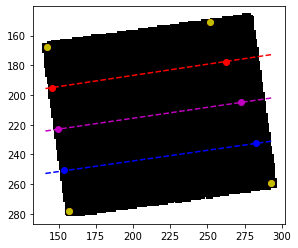

,lmid50_x,lmid50_y,rmid50_x,rmid50_y,m50,b50,lmid25_x,lmid25_y,rmid25_x,rmid25_y,m25,b25,lmid75_x,lmid75_y,rmid75_x,rmid75_y,m75,b75
BoxID,,,,,,,,,,,,,,,,,,
174,149.5,223.0,272.5,205.0,-0.146341,244.878049,145.75,195.5,262.25,178.0,-0.150215,216.829268,153.25,250.5,282.75,232.0,-0.142857,272.926829


In [23]:
# create dictionary to store each terminus box ndarray by BoxID
termboxes2 = {}
  
# Create dictionaries and lists to store coordinates
topleft_coords = {}; bottomleft_coords = {}; topright_coords = {} ;bottomright_coords = {}
#create lists to store the left midpoints (1C) and right midpoints (2C)
midpoints_x = []; midpoints_y = []; midpoints_r_x = []; midpoints_r_y = []
mids_l025_x = []; mids_l025_y = []; mids_r025_x = []; mids_r025_y = []
mids_l075_x = []; mids_l075_y = []; mids_r075_x = []; mids_r075_y = []
#create lists to store the slopes and intercepts of the flowline equations
slope_50 = []; intercept_50 = []; slope_25 = []; intercept_25 = []; slope_75 = []; intercept_75 = []; boxes = []

# read in the terminus box rasters
for BoxID in BoxIDs:
    ######################################################################################
    # load in the terminus box raster
#     boxpath = basepath+"Box"+BoxID+"/rotated_images/final/crop_Box"+BoxID+"_raster_cut.pgm"
    boxpath = '/media/jukes/easystore/TEMP_STORE_FROM_JUKES1/' # path to rotated terminus boxes
    boxpath+= "Box"+BoxID+"/rotated_c1/R_Box"+BoxID+"_raster_cut.png" # modify the path
    ######################################################################################
    
    termbox = cv2.imread(boxpath) # read the raster into an ndarray
    termbox = cv2.cvtColor(termbox, cv2.COLOR_BGR2GRAY) 
       
    boxes_xcoords = {}; boxes_ycoords = {} # dictionary to store the coordinates of the box pixels    
    # from the raster, grab x,y coordinates of pixels correpsonding to the terminus box
    BOI = termbox
    if len(BOI.shape) > 2:
        yindices, xindices, third= np.where(BOI > 0) # keep the pixels of where the box exists
    else:
        yindices, xindices= np.where(BOI > 0) # keep the pixels of where the box exists
    boxes_ycoords.update({BoxID: yindices}); boxes_xcoords.update({BoxID: xindices}) # add to the dictionary
    
    # set 0.95*minimum dimension as the minimum distance between corners
    min_dist = 0.9*int(dim_df.loc[BoxID]['min_dim_px'])
    
    # FIND CORNERS:
    quality = 0.1 # quality threshold for corner tracking
    corners = cv2.goodFeaturesToTrack(termbox,4,quality,min_dist)
    
    cornerxs = []; cornerys = [] # hold corner coordinates
    for i in range(0, 4):
        cornerxs.append(corners[i][0][0]); cornerys.append(corners[i][0][1])
    cornerxs = np.array(cornerxs); cornerys = np.array(cornerys) 
    
    # IDENTIFY THE TWO LEFT COORDINATES:
    # two minimum x values:
    [x1,x2] = np.sort(cornerxs)[:2]
    if x1 == x2:
        print('Two of the same x coordinates, with y:', np.where(cornerxs == x1)[0])
        [x1_i, x2_i] = np.where(cornerxs == x1)[0]
    else:
        x1_i = np.where(cornerxs == x1)[0][0]; x2_i = np.where(cornerxs == x2)[0][0]
    # pair the x and y
    coord1 = [x1, cornerys[x1_i]]; coord2 = [x2,cornerys[x2_i]]
    [ytopleft, ybottomleft] = np.sort([cornerys[x1_i], cornerys[x2_i]])
    for coord in [coord1, coord2]:
        if coord[1] == ytopleft:
            topleft = coord
        elif coord[1] == ybottomleft:
            bottomleft = coord
    
    # IDENTIFY THE TWO RIGHT COORDINATES
    [x3,x4] = np.sort(cornerxs)[2:]
    if x3 == x4:
        print('Two of the same x coordinates, with y:', np.where(cornerxs == x3)[0])
        [x3_i, x4_i] = np.where(cornerxs == x3)[0]
    else:
        x3_i = np.where(cornerxs == x3)[0][0]; x4_i = np.where(cornerxs == x4)[0][0]
    # pair the x and y
    coord3 = [x3, cornerys[x3_i]]; coord4 = [x4,cornerys[x4_i]]
    [ytopright, ybottomright] = np.sort([cornerys[x3_i], cornerys[x4_i]])
    for coord in [coord3, coord4]:
        if coord[1] == ytopright:
            topright = coord
        elif coord[1] == ybottomright:
            bottomright= coord
    
    # add the corner coordinates to the respective dictionaries:
    topleft_coords.update({BoxID: topleft})
    bottomright_coords.update({BoxID: bottomright})
    bottomleft_coords.update({BoxID: bottomleft}) #Add to dictionary of bottomleft coordinates
    topright_coords.update({BoxID: topright})
    
    # CALCULATE THE MIDPOINTS USING MIDPOINT FUNCTION
    midpoint_x, midpoint_y = midpoint(topleft[0], topleft[1], bottomleft[0], bottomleft[1])
    midpoint_r_x, midpoint_r_y = midpoint(topright[0], topright[1], bottomright[0], bottomright[1])
    # GRAB 1/4th and 3/4ths lines (midpoints)
    mid_l025_x, mid_l025_y = midpoint(topleft[0], topleft[1], midpoint_x, midpoint_y)
    mid_r025_x, mid_r025_y = midpoint(topright[0], topright[1], midpoint_r_x, midpoint_r_y) 
    mid_l075_x, mid_l075_y = midpoint(bottomleft[0], bottomleft[1], midpoint_x, midpoint_y)
    mid_r075_x, mid_r075_y = midpoint(bottomright[0], bottomright[1], midpoint_r_x, midpoint_r_y)
    
    # CALCULATE FLOWLINE EQUATIONS (b = y-mx)
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x);b = midpoint_y - (m*midpoint_x)
    m025 = (mid_r025_y-mid_l025_y)/(mid_r025_x-mid_l025_x); b025 = mid_l025_y - (m*mid_l025_x)
    m075 = (mid_r075_y-mid_l075_y)/(mid_r075_x-mid_l075_x); b075 = mid_l075_y - (m*mid_l075_x)
    
    # append BoxIDs, slopes, intercepts, midpoints, and flowlines to lists
    boxes.append(BoxID);
    midpoints_x.append(midpoint_x); midpoints_y.append(midpoint_y)
    midpoints_r_x.append(midpoint_r_x); midpoints_r_y.append(midpoint_r_y)  
    mids_l025_x.append(mid_l025_x); mids_l025_y.append(mid_l025_y); 
    mids_r025_x.append(mid_r025_x); mids_r025_y.append(mid_r025_y)
    mids_l075_x.append(mid_l075_x) ;mids_l075_y.append(mid_l075_y) ;
    mids_r075_x.append(mid_r075_x) ;mids_r075_y.append(mid_r075_y)
    slope_50.append(m); intercept_50.append(b); 
    slope_25.append(m025); intercept_25.append(b025)
    slope_75.append(m075); intercept_75.append(b075)
    
    # PLOT THE RESULTS
    print(BoxID)
    plt.scatter(boxes_xcoords[BoxID], boxes_ycoords[BoxID], c='k',marker='s')
    # plot corners
    for j in range(0, 4):
        corner = corners[j][0]; #print(corner)
        plt.scatter(corner[0], corner[1], c='r') 
    # plot the vertices
    plt.scatter(topleft[0], topleft[1], c='y')
    plt.scatter(bottomleft[0], bottomleft[1], c='y')
    plt.scatter(topright[0], topright[1], c='y')
    plt.scatter(bottomright[0], bottomright[1], c='y')
    # plot midpoints
    plt.scatter(midpoint_x, midpoint_y, c='m'); plt.scatter(midpoint_r_x, midpoint_r_y, c='m')
    plt.scatter(mid_l025_x, mid_l025_y, c='r'); plt.scatter(mid_r025_x, mid_r025_y, c='r')
    plt.scatter(mid_l075_x, mid_l075_y, c='b'); plt.scatter(mid_r075_x, mid_r075_y, c='b')
    # plot the flowlines in cyan
    x=np.linspace(np.min(boxes_xcoords[BoxID]), np.max(boxes_xcoords[BoxID])); 
    y50=m*x + b; y25=m025*x + b025; y75=m075*x + b075
    plt.plot(x, y50, '--m', x, y25, '--r', x, y75, '--b')
    plt.gca().invert_yaxis(); plt.axis('scaled'); plt.show()
        
    #add the ndarray into a dictionary with the BoxID as the key
    termboxes2.update({BoxID: termbox})
    
# create a dataframe
total_df = pd.DataFrame(list(zip(boxes, midpoints_x, midpoints_y, midpoints_r_x, midpoints_r_y, slope_50, 
                                 intercept_50, mids_l025_x, mids_l025_y, mids_r025_x, mids_r025_y, slope_25, 
                                 intercept_25, mids_l075_x, mids_l075_y, mids_r075_x, mids_r075_y, slope_75, 
                                intercept_75)), 
                        columns=['BoxID', 'lmid50_x', 'lmid50_y', 'rmid50_x','rmid50_y', 'm50', 'b50',
                                 'lmid25_x', 'lmid25_y','rmid25_x','rmid25_y', 'm25', 'b25',
                                 'lmid75_x', 'lmid75_y', 'rmid75_x','rmid75_y', 'm75', 'b75'])

total_df = total_df.set_index('BoxID')
total_df

## 2.2) Try second method for those where first method failed

Visually inspect the results plotted above. If the flowlines for certain glaciers are not generated as well as you'd like, identify those here and try this method.

In [24]:
######################################################################################
# identify trouble boxes:
BoxIDs_trouble = ['184']
######################################################################################

# remove the bad results from total_df
total_df = total_df.drop(BoxIDs_trouble)

KeyError: "['184'] not found in axis"

In [8]:
boxes_xcoords = {}; boxes_ycoords = {} # dictionary to store the all coordinates of the box rasters
topleft_coords = {}; bottomleft_coords = {} # dictionaries for the box vertices
topright_coords = {}; bottomright_coords = {}
# lists to store the left and right quarter points:
midpoints_x = []; midpoints_y = []; midpoints_r_x = []; midpoints_r_y = []
mids_l025_x = []; mids_l025_y = []; mids_r025_x = []; mids_r025_y = []
mids_l075_x = []; mids_l075_y = []; mids_r075_x = []; mids_r075_y = []
# lists to store the slopes and intercepts of the flowline equations
slope_50 = []; intercept_50 = []; slope_25 = []; intercept_25 = []; slope_75 = []; intercept_75 = []; boxes = []

# for those trouble boxes identified
for BoxID in BoxIDs_trouble:
    BOI = termboxes2[BoxID] # grab the box raster
    if len(BOI.shape) > 2:
        yindices, xindices, third= np.where(BOI > 0) # keep the coordinates of the box pixels
    else:
        yindices, xindices= np.where(BOI > 0) # keep the coordinates of the box pixels
    boxes_ycoords.update({BoxID: yindices}); boxes_xcoords.update({BoxID: xindices}) # add to the dictionary
    
    ######################################################################################
    # THIS IS WHERE YOU CAN MANUALLY ENTER VERTICES IN PIXEL COORDINATES FOR CERTAIN GLACIERS.
    # Glacier 259 is an example. You can add create your own if condition and 
    # add elseifs if there are more to manually enter. If you have no manual entries,
    # uncomment the True == False if statement and comment the rest out, which will just 
    # skip to the code after else.
    
#     if True == False: 
    if BoxID == '259':
        topleft = [117.0, 355.0] # x,y
        bottomleft = [166.0, 426.0]
        topright = [386.0, 169.0]
        bottomright = [435.0, 239.0]
    ######################################################################################
    else:
        # FIND THE TOP LEFT COORDINATES (min x and min y)
        xy = xindices*yindices
        min_xy_i = np.where(xy == np.nanmin(xy))[0][0]  #Find the x and y pair corresponding to that lowest xy
        topleft = [xindices[min_xy_i], yindices[min_xy_i]]

        # FIND THE BOTTOM RIGHT COORDINATES (highest x*y)
        max_xy = np.nanmax(xy)
        max_xy_i = np.where(xy == max_xy)[0][0]
        bottomright = [xindices[max_xy_i], yindices[max_xy_i]]
        
        # FIND THE BOTTOM LEFT COORDINATE(highest y/x)
        y_x = yindices/xindices
        max_y_x = np.nanmax(y_x) #Find the highest y/x value
        #Find the x and y pair corresponding to that y/x using the index
        max_y_x_i = np.where(y_x == max_y_x)[0][0]
        bottomleft = [xindices[max_y_x_i], yindices[max_y_x_i]]
        
        # FIND THE TOP RIGHT COORDINATES (highest x/y)
        x_y = xindices/yindices
        max_x_y = np.nanmax(x_y)  # find highest x/y value
        max_x_y_i = np.where(x_y == max_x_y)[0][0]  #Find the x, y pair correpsonding to the maximum x/y using the index
        topright = [xindices[max_x_y_i], yindices[max_x_y_i]]
    
    # add to dictionaries:
    topleft_coords.update({BoxID: topleft})
    bottomright_coords.update({BoxID: bottomright})
    bottomleft_coords.update({BoxID: bottomleft})
    topright_coords.update({BoxID: topright})
    
    # CALCULATE THE MIDPOINTS
    midpoint_x, midpoint_y = midpoint(topleft[0], topleft[1], bottomleft[0], bottomleft[1]) # left
    midpoint_r_x, midpoint_r_y = midpoint(topright[0], topright[1], bottomright[0], bottomright[1]) # right
    
    # GRAB 1/4th AND 3/4ths LINES (another midpoint calculation)
    mid_l025_x, mid_l025_y = midpoint(topleft[0], topleft[1], midpoint_x, midpoint_y)
    mid_r025_x, mid_r025_y = midpoint(topright[0], topright[1], midpoint_r_x, midpoint_r_y) 
    mid_l075_x, mid_l075_y = midpoint(bottomleft[0], bottomleft[1], midpoint_x, midpoint_y)
    mid_r075_x, mid_r075_y = midpoint(bottomright[0], bottomright[1], midpoint_r_x, midpoint_r_y)
    
    # CALCULATE FLOWLINE EQUATIONS (y_intercept = y1 - m*x1)
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x);b = midpoint_y - (m*midpoint_x) # 1/2 flowline
    m025 = (mid_r025_y-mid_l025_y)/(mid_r025_x-mid_l025_x); b025 = mid_l025_y - (m*mid_l025_x) # 1/4 flowline
    m075 = (mid_r075_y-mid_l075_y)/(mid_r075_x-mid_l075_x); b075 = mid_l075_y - (m*mid_l075_x) # 3/4 flowline
    
    # append BoxIDs, slopes, intercepts, midpoints, and flowlines to lists
    boxes.append(BoxID);
    midpoints_x.append(midpoint_x); midpoints_y.append(midpoint_y)
    midpoints_r_x.append(midpoint_r_x); midpoints_r_y.append(midpoint_r_y)  
    mids_l025_x.append(mid_l025_x); mids_l025_y.append(mid_l025_y); 
    mids_r025_x.append(mid_r025_x); mids_r025_y.append(mid_r025_y)
    mids_l075_x.append(mid_l075_x) ;mids_l075_y.append(mid_l075_y) ;
    mids_r075_x.append(mid_r075_x) ;mids_r075_y.append(mid_r075_y)
    slope_50.append(m); intercept_50.append(b); 
    slope_25.append(m025); intercept_25.append(b025)
    slope_75.append(m075); intercept_75.append(b075)
    
# create a new dataframe
df2 = pd.DataFrame(list(zip(boxes, midpoints_x, midpoints_y, midpoints_r_x, midpoints_r_y, slope_50, 
                                 intercept_50, mids_l025_x, mids_l025_y, mids_r025_x, mids_r025_y, slope_25, 
                                 intercept_25, mids_l075_x, mids_l075_y, mids_r075_x, mids_r075_y, slope_75, 
                                intercept_75)), 
                        columns=['BoxID', 'lmid50_x', 'lmid50_y', 'rmid50_x','rmid50_y', 'm50', 'b50',
                                 'lmid25_x', 'lmid25_y','rmid25_x','rmid25_y', 'm25', 'b25',
                                 'lmid75_x', 'lmid75_y', 'rmid75_x','rmid75_y', 'm75', 'b75'])

df2 = df2.set_index('BoxID')
df2

,lmid50_x,lmid50_y,rmid50_x,rmid50_y,m50,b50,lmid25_x,lmid25_y,rmid25_x,rmid25_y,m25,b25,lmid75_x,lmid75_y,rmid75_x,rmid75_y,m75,b75
BoxID,,,,,,,,,,,,,,,,,,
184,293.0,562.0,551.0,431.5,-0.505814,710.203488,293.0,561.5,548.0,382.75,-0.70098,709.703488,293.0,562.5,554.0,480.25,-0.315134,710.703488


## Now check the new flowline results:

In [25]:
for BOI_ID in BoxIDs_trouble:
#     if BOI_ID == '184': # to select one glacier at a time
        print(BOI_ID)
        # plot the raster pixels in black
        plt.scatter(boxes_xcoords[BOI_ID], boxes_ycoords[BOI_ID], c='k',marker='s')
        # plot the vertices
        plt.scatter(topleft_coords[BOI_ID][0], topleft_coords[BOI_ID][1], c='y')
        plt.scatter(bottomleft_coords[BOI_ID][0], bottomleft_coords[BOI_ID][1], c='y')
        plt.scatter(topright_coords[BOI_ID][0], topright_coords[BOI_ID][1], c='y')
        plt.scatter(bottomright_coords[BOI_ID][0], bottomright_coords[BOI_ID][1], c='y')
        # plot midpoints
        plt.scatter(df2.at[BOI_ID,'lmid50_x'], df2.at[BOI_ID,'lmid50_y'], c='m'); plt.scatter(df2.at[BOI_ID, 'rmid50_x'], df2.at[BOI_ID, 'rmid50_y'], c='m')
        plt.scatter(df2.at[BOI_ID,'lmid25_x'], df2.at[BOI_ID,'lmid25_y'], c='r'); plt.scatter(df2.at[BOI_ID, 'rmid25_x'], df2.at[BOI_ID, 'rmid25_y'], c='r')
        plt.scatter(df2.at[BOI_ID,'lmid75_x'], df2.at[BOI_ID,'lmid75_y'], c='b'); plt.scatter(df2.at[BOI_ID, 'rmid75_x'], df2.at[BOI_ID, 'rmid75_y'], c='b')
        # plot the flowlines in cyan
        x=np.linspace(np.min(boxes_xcoords[BOI_ID]), np.max(boxes_xcoords[BOI_ID])); y50=(df2.at[BOI_ID, 'm50'])*x + (df2.at[BOI_ID, 'b50']); 
        y25=(df2.at[BOI_ID, 'm25'])*x + (df2.at[BOI_ID, 'b25']); y75=(df2.at[BOI_ID, 'm75'])*x + (df2.at[BOI_ID, 'b75'])
        plt.plot(x, y50, '--m', x, y25, '--r', x, y75, '--b')
        # plot parameters      
        plt.gca().invert_yaxis(); plt.axis('scaled'); plt.show()

184


KeyError: '184'

## If the flowlines are still not properly generated, edit the code cell above to manually enter the box corners in image coordinates.

## If successful, add these back to the full data table:

In [19]:
total_df = pd.concat([total_df, df2])
total_df = total_df.drop(['rmid50_y', 'rmid25_y', 'rmid75_y'], axis=1) # drop the righthand points
# we only need the left
# total_df # show the resulting dataframe

## Save the box image coordinates to CSV file

In [27]:
FLINE_FILENAME = 'Boxes_coords_pathrows_'
######################################################################################
FLINE_FILENAME += '174.csv' # change here
######################################################################################
total_df.to_csv(path_or_buf = basepath+FLINE_FILENAME, sep=',')

# 3) Generate the terminus position time series

In [73]:
# ######################################################################################
path = '/media/jukes/easystore/TEMP_STORE_FROM_JUKES1/' # path to all Box### folders with rotated images

# enter names of CSV files generated during pre-processing
csvpath = '/home/jukes/Documents/Sample_glaciers/'
DATES_FILENAME = 'imgdates_SE_1.csv'
FLINE_FILENAME = 'Boxes_coords_pathrows_SE_1.csv'
VEL_FILENAME = 'Glacier_vel_manual_all.csv'
filedate = '2022_01_04' # date that you ran the WTMM terminus picking (in the terminus pick file name)

# These are the recommended values used for time series filtering
V = 3 # flow speed scalar multiplier (increase to filter more, decrease to filter less)
N1 = 1 # number of iterations to remove dips (sudden drop below average)
N2 = 1 # number of iterations to remove jumps (sudden jump above average)
# ######################################################################################

## 3.1) Generate terminus positions using results produced with python wtmm2d:

In [76]:
# read in csv files
# IMAGE DATES
datetime_df = pd.read_csv(csvpath+DATES_FILENAME, sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])
    
# CENTERLINE INFO
centerline_df = pd.read_csv(csvpath+FLINE_FILENAME, sep=',', dtype=str, header=0)
centerline_df = centerline_df.set_index('BoxID')
    
# GLACIER VELOCITIES
flowspeed_df= pd.read_csv(csvpath+VEL_FILENAME, sep=',', dtype=str)
flowspeed_df = flowspeed_df.set_index('BoxID')

In [66]:
# set BoxIDs
# BoxIDs = ['174']
# BoxIDs = list(centerline_df.index) # List of BoxIDs
BoxIDs = list(pd.read_csv(csvpath+'Buffdist_SE_1.csv',dtype=str).BoxID); BoxIDs = BoxIDs[:8]
print(BoxIDs)

['179', '095', '281', '161', '071', '119', '209', '197']


In [80]:
def get_results(BOI):
    print("Box"+BOI)
    chainpath = path+'Box'+BOI+'/rotated_c1/'
    
    # remove empty chain folders           
    for file in os.listdir(chainpath):
        if file.endswith('chains'):
            # remove empty chain folders
            if len(os.listdir(chainpath+file)) == 0:
                os.rmdir(chainpath+file)
    
    # LOAD IN TERMINUS PICK FILE
    termpick_df = pd.read_csv(csvpath+'terminuspicks_Box'+BOI+'_'+filedate+'.csv')
    
    #CALCULATE TERMINUS POSITIONS
    # LOAD IN REFERENCE POINTS to calculate terminus position with respect to
    box_midpoint_x = np.float(centerline_df.loc[BOI, 'lmid50_x']); box_midpoint_y = np.float(centerline_df.loc[BOI, 'lmid50_y'])
    boxmid_x_25 = np.float(centerline_df.loc[BOI, 'lmid25_x']); boxmid_y_25 = np.float(centerline_df.loc[BOI, 'lmid25_y'])
    boxmid_x_75 = np.float(centerline_df.loc[BOI, 'lmid75_x']); boxmid_y_75 = np.float(centerline_df.loc[BOI, 'lmid75_y'])

    #GRAB CENTERLINE POINTS
    #grab slopes and intercepts from the dataframe
    c_slope = float(centerline_df.loc[BOI]['m50']); c_intercept = float(centerline_df.loc[BOI]['b50']) 
    c25_slope = float(centerline_df.loc[BOI]['m25']); c25_intercept = float(centerline_df.loc[BOI]['b25'])
    c75_slope = float(centerline_df.loc[BOI]['m75']); c75_intercept = float(centerline_df.loc[BOI]['b75'])  

    #grab range of x-values
    xmin50 = float(box_midpoint_x); xmax50 = float(centerline_df.loc[BOI, 'rmid50_x']); ymid50 = float(box_midpoint_y)
    xmin25 = float(boxmid_x_25); xmax25 = float(centerline_df.loc[BOI, 'rmid25_x']); ymid25 = float(boxmid_y_25)
    xmin75 = float(boxmid_x_75); xmax75 = float(centerline_df.loc[BOI, 'lmid75_x']); ymid75 = float(boxmid_y_75)
    xmax = np.max([xmax50, xmax25, xmax75]); xmin = np.min([xmin50, xmin25, xmin75]); c_x = np.linspace(xmin, xmax, int(xmax-xmin)*2)

    #calculate y-values using the various centerlines
    c_y = c_slope*c_x + c_intercept; c_y_25 = c25_slope*c_x + c25_intercept; c_y_75 = c75_slope*c_x + c75_intercept

    # LISTS TO HOLD TERMINUS POSITIONS AND INTERSECTION POINTS
    terminus_positions = []; tpositions_25 = []; tpositions_75 = []
    intersections = []; X25 = []; X75 = []
    
    for index, row in termpick_df.iterrows():
        intersect_xs = []; intersect_xs_25 = []; intersect_xs_75 = []
        intersect_ys = []; intersect_ys_25 = []; intersect_ys_75 = []
        scale = str(row['Scale']).zfill(3)
        scene = row['Scene']
        
        # read in chain jsons
        with open(chainpath+'R_'+scene+'_B8_Buffer'+BOI+'_PS.pgm_chains/'+scale+'_chain.json') as f:
            data = json.load(f)
        dat_xs = np.array(data.get('ix'))
        dat_ys = np.array(data.get('iy'))
            
        for l in range(0, len(c_x)):
            x = c_x[l]; y = c_y[l]; y25 = c_y_25[l]; y75 = c_y_75[l]        
            interval = 0.8 # pixels between points
            for k in range(0, len(dat_xs)):
                dat_x = dat_xs[k]; dat_y = dat_ys[k]
#                 print(x, dat_x)
                #midway centerline
                if within(dat_x, x, interval) and within(dat_y, y, interval):
                    intersect_xs.append(dat_x); intersect_ys.append(dat_y)  
#                     print(x, dat_x)
                #1/4th centerline
                if within(dat_x, x, interval) and within(dat_y, y25, interval):
                    intersect_xs_25.append(dat_x); intersect_ys_25.append(dat_y)              
                #3/4th centerline
                if within(dat_x, x, interval) and within(dat_y, y75, interval):
                    intersect_xs_75.append(dat_x); intersect_ys_75.append(dat_y)
                    
        #for 50 centerline
        if len(intersect_xs) == 0: #if no intersections are found with the terminus line, append Nans to tpos
            tpos50 = np.NaN; intersect_x = np.NaN; intersect_y = np.NaN
        else: #if at least one is found:
            #intersection with the greatest x (use distance formula to calculate distance between)
            max_index = intersect_xs.index(np.max(intersect_xs))
            intersect_x = intersect_xs[max_index]; intersect_y = intersect_ys[max_index]
            tpos50 = (intersect_x-xmin50)*15.0

        #repeat for for 25 centerline
        if len(intersect_xs_25) == 0:
            tpos25 = np.NaN; intersect_x25 = np.NaN; intersect_y25 = np.NaN
        else:
            max_index_25 = intersect_xs_25.index(np.max(intersect_xs_25))
            intersect_x25 = intersect_xs_25[max_index_25]; intersect_y25 = intersect_ys_25[max_index_25]
            tpos25 = (intersect_x25-xmin25)*15.0

        #for 75 centerline
        if len(intersect_xs_75) == 0:
            tpos75 = np.NaN; intersect_x75 = np.NaN; intersect_y75 = np.NaN
        else:
            max_index_75 = intersect_xs_75.index(np.max(intersect_xs_75))
            intersect_x75 = intersect_xs_75[max_index_75]; intersect_y75 = intersect_ys_75[max_index_75]
            tpos75 = (intersect_x75-xmin75)*15.0

        #append to lists
        terminus_positions.append(tpos50); tpositions_25.append(tpos25); tpositions_75.append(tpos75)
        intersections.append([intersect_x, intersect_y]); X25.append([intersect_x25, intersect_y25]); X75.append([intersect_x75, intersect_y75])            
    
    # ADD TERMINUS POSITION AND INTERSECTIONS TO THE DATAFRAME
    termpick_df['tpos50'] = terminus_positions; termpick_df['tpos25'] = tpositions_25; termpick_df['tpos75'] = tpositions_75
    termpick_df['X50'] = intersections ;termpick_df['X25'] = X25; termpick_df['X75'] = X75

    # SPLIT INTO 3 DATAFRAMES FOR 3 FLOWLINES:
    df_50 = termpick_df[['Scene', 'BoxID', 'Scale', 'datetimes', 'Metric', 'Order', 
                                          'tpos50', 'X50',]].copy().reset_index(drop=True)
    df_50 = df_50.rename(columns={"tpos50": "tpos", "X50": "X"})
    df_25 = termpick_df[['Scene', 'BoxID', 'Scale', 'datetimes', 'Metric', 'Order', 
                                          'tpos25', 'X25']].copy().reset_index(drop=True)
    df_25 = df_25.rename(columns={"tpos25": "tpos", "X25": "X"})
    df_75 = termpick_df[['Scene', 'BoxID', 'Scale', 'datetimes', 'Metric', 'Order', 
                                          'tpos75', 'X75']].copy().reset_index(drop=True)
    df_75 = df_75.rename(columns={"tpos75": "tpos", "X75": "X"})
    
    dfs = [df_50, df_25, df_75]

    # CALCULATE TERMINUS CHANGE RATES
    dfs_new = []
    for df in dfs: 
        to_datetimes(df); dfs_new.append(calc_changerates1(df))

    #FILTER USING 5*MAXIMUM FLOW SPEEDS
    max_flow = float(flowspeed_df['Max_speed'][BOI])
    if max_flow < 1.0:
        flow_thresh = V
    else:
        flow_thresh = V*max_flow
    #remove dips
    nodips = []
    for df in dfs_new:
        nodips.append(remove_dips(df, flow_thresh, N1))
    #remove jumps 
    nojumps = []
    for df in nodips:
        nojumps.append(remove_jumps(df, flow_thresh, N2))
        
    stop = 0
    #stop the process if there are no points remaining after filtering
    for df in nojumps:
        if len(df) == 0:
            stop = 1
    if stop == 0:
    #GRAB HIGHEST ORDER PICK AFTER FILTERING
        highestorder_dfs = []
        for df in nojumps:
            #grab unique dates
            unique_dates = set(list(df['datetimes']))
            #grab highest orders:
            order_list = []
            for date in unique_dates:
                date_df = df[df['datetimes'] == date].copy()
                highestorder = np.min(np.array(date_df['Order']))
                order_list.append(highestorder)
            highestorder_df = pd.DataFrame(list(zip(unique_dates, order_list)), columns=['datetimes', 'Order']).sort_values(by='datetimes', ascending=True)
            highestorder_dfs.append(highestorder_df)

        onepick_dfs = []
        for i in range(0, len(highestorder_dfs)):
            onepick_df = nojumps[i].merge(highestorder_dfs[i], how='inner', on=['datetimes', 'Order'])
            onepick_dfs.append(onepick_df)

        #PLOT AND SAVE
        fig, ax1 = plt.subplots(figsize=(12,4))
        colors = pl.cm.viridis(np.linspace(0,0.5,3)) # generate 3 centerline colors using Dark2 scheme
        for j in range(0, len(onepick_dfs)):
            df = onepick_dfs[j];    print(len(df))
            ax1.plot(df['datetimes'], df['tpos'], marker = 'o', linewidth=0, color=colors[j], markersize=5, alpha=0.7)
        #general plot parameters
        ax1.set_ylabel('Terminus position (m)', color='k', fontsize=12)
        ax1.set_title("Box"+BOI, fontsize=16); ax1.set_xlabel('Date', fontsize=12)
        ax1.tick_params(axis='both', which='major', labelsize=12)
        #save figure
        plt.legend(['1/2', '1/4', '3/4'])
        plt.savefig(csvpath+"/Figures/Termposition_LS8_m_Box"+BOI+"_"+filedate+".png", dpi=200)
        plt.show()

        flowlines = ['flowline50', 'flowline25', 'flowline75']
        for k in range(0, len(onepick_dfs)):
            df = onepick_dfs[k];
            df.to_csv(path_or_buf = csvpath+'Tpos_Box'+BOI+'_'+flowlines[k]+'_filtered_py.csv', sep=',')


### 3.1.1) Option 1: Run in series (loop):

Box179


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 0 dips
Dropping 8 dips
Dropping 12 dips
Dropping 24 jumps
Dropping 26 jumps
Dropping 73 jumps
85
76
83


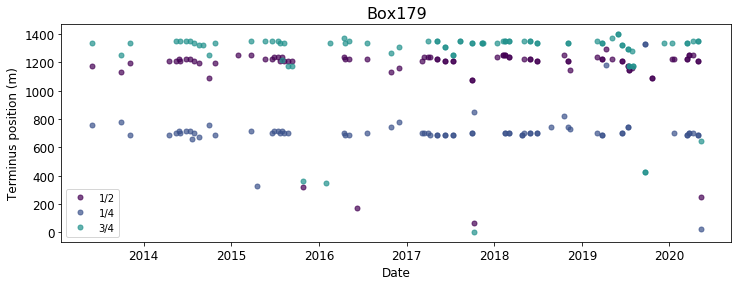

Box095


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 9 dips


KeyboardInterrupt: 

In [82]:
for BoxID in BoxIDs:
    get_results(BoxID)

### 3.1.2) Option 2: Run in parallel (batches):

In [94]:
# check number of cpus on machine using os:
print(os.cpu_count(), 'CPUs on the machine')

################################################################################################
# set batch size accordingly
# recommendation is to leave one or two cpus available for other background processing
batch_size = 10
print('Batch size:',batch_size)
################################################################################################

12 CPUs on the machine
Batch size: 5


In [95]:
nbatches = int(np.ceil(len(BoxIDs)/batch_size)) # round up to the next batch size
nfullbatches = int(np.floor(len(BoxIDs)/batch_size)) # number of full batches
print(nbatches, 'batches')
print(nfullbatches, 'full batches')

2 batches
1 full batches


Box179
Box095
Box161
Box281
Box071
Dropping 4 dips
Dropping 0 dips
Dropping 0 dips
Dropping 0 dips
Dropping 0 dips
Dropping 18 dips
Dropping 8 jumps
Dropping 0 jumps
Dropping 11 jumps
Dropping 61 jumps
89
81
92


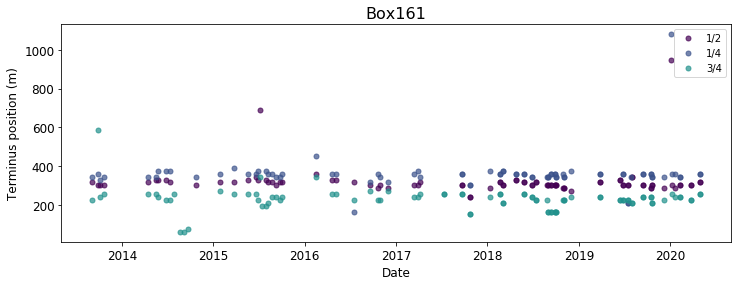

Dropping 7 jumps
Dropping 34 jumps
137
134
125


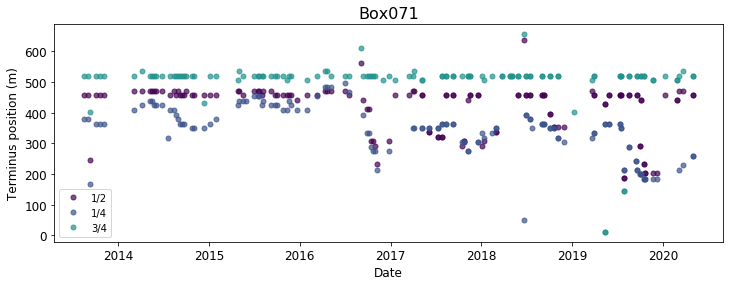

Dropping 9 dips
Dropping 5 dips
Dropping 5 dips
Dropping 63 jumps
Dropping 39 jumps
Dropping 0 dips
Dropping 8 dips
Dropping 12 dips
Dropping 24 jumps
Dropping 26 jumps
Dropping 73 jumps
85
76
83


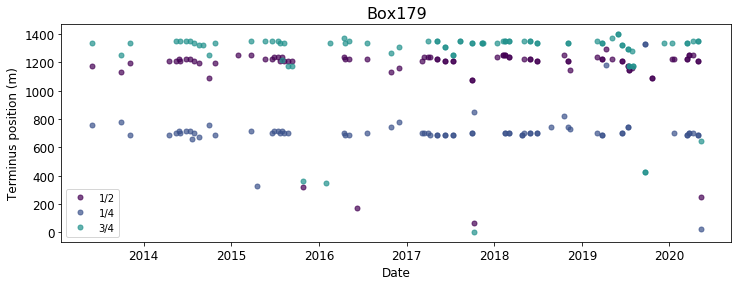

Dropping 52 jumps
237
238
235


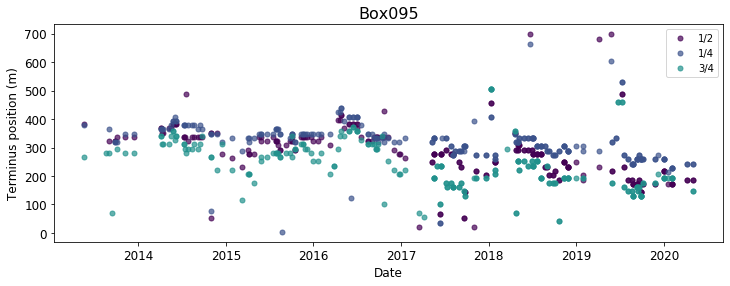

Dropping 3 dips
Dropping 9 dips
Dropping 0 dips
Dropping 14 jumps
Dropping 52 jumps
Dropping 46 jumps
95
109
46


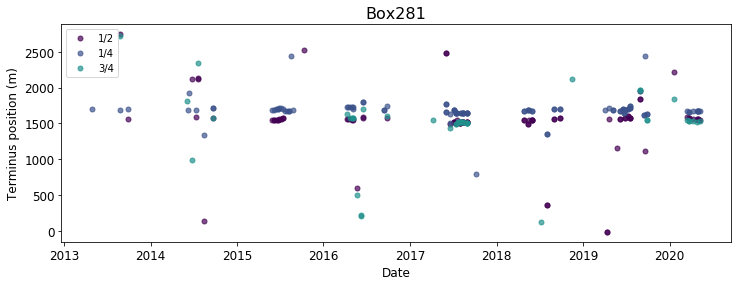

Box209
Box119
Box197
Dropping 0 dips
Dropping 10 dips
Dropping 9 dips
Dropping 0 dips
Dropping 20 jumps
Dropping 36 jumps
Dropping 46 jumps
44
43
29


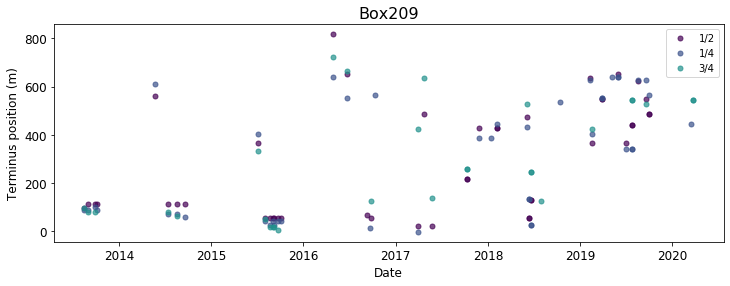

Dropping 5 dips


Process ForkPoolWorker-46:
Process ForkPoolWorker-48:
Process ForkPoolWorker-44:
Process ForkPoolWorker-31:
Process ForkPoolWorker-35:
Process ForkPoolWorker-28:
Process ForkPoolWorker-39:
Process ForkPoolWorker-34:
Process ForkPoolWorker-38:
Process ForkPoolWorker-25:
Process ForkPoolWorker-30:
Process ForkPoolWorker-29:
Process ForkPoolWorker-26:
Process ForkPoolWorker-32:


KeyboardInterrupt: 

Process ForkPoolWorker-33:
Process ForkPoolWorker-41:
Process ForkPoolWorker-47:
Process ForkPoolWorker-37:
Process ForkPoolWorker-40:
Process ForkPoolWorker-43:
Process ForkPoolWorker-45:
Process ForkPoolWorker-27:
Process ForkPoolWorker-42:
Process ForkPoolWorker-36:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback

  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/jukes/anaconda3/lib/python3.7/mult

KeyboardInterrupt
KeyboardInterrupt
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/jukes/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


In [97]:
# full batches
for b in range(0, nfullbatches):
    pool = Pool() # initialize pool
    batchids = BoxIDs[b*batch_size:(b+1)*batch_size]
    pool.map(get_results, batchids) # process all in pool
    
# for the last batch
if nbatches - nfullbatches == 1:
    pool = Pool()
    lastbatchids = BoxIDs[(b+1)*batch_size:] # grab all remaining images
    pool.map(get_results, lastbatchids) # process all in pool
#         print(lastbatchimgs)


## 3.2) Generate terminus positions using results produced through Xsmurf 2D WTMM:

If you processed the glaciers using wtmm2d_terminuspick_Xsmurf.ipynb, use this following function. No parallel processing option available.

In [1]:
# results_allglaciers(DATES_FILENAME,FLINE_FILENAME,VEL_FILENAME, date, V, N1, N2)